# Scenarios generate worlds

In this tutorial we take a closer look at how scenarios generate world.

The YAML description of a  scenario lists groups of agents. For example, 

In [1]:
from navground import sim

scenario = sim.load_scenario("""
groups:
  - number: 1
    radius: 1
""")

describes a single group composed of one agent of radius 1. All the details about the agent are unknown at this point. 

We can generate a world with these specifics

In [2]:
world = scenario.make_world()

that will contains a single agent of radius 1

In [3]:
world.agents[0].radius

1.0

## Everything is a sampler

In a scenario, almost every attribute corresponds to a sampler. Specify a single number for the radius is actually setting up the sampler for radius to always generate 1.

Let us be more specific, an define the equivalent scenario with an explicit sampler

In [4]:
scenario = sim.load_scenario("""
groups:
  - number: 1
    radius:
      sampler: constant
      value: 1
""")

In [5]:
world = scenario.make_world()
world.agents[0].radius

1.0

Let us pick a more interesting sampler. For instance, we may want the radii of the agent to be uniformly distributed in [0.5, 1.5] instead:

In [6]:
scenario = sim.load_scenario("""
groups:
  - number: 1
    radius:
      sampler: uniform
      from: 0.5
      to: 1.5
""")

It is very important that experiments are reproducible. Therefore, samplers should be generate reproducible values too, which does happen if we speficy the same seed.  

In [7]:
for _ in range(5):
    world = scenario.make_world(seed=1)
    print(world.agents[0].radius)

0.9170219898223877
0.9170219898223877
0.9170219898223877
0.9170219898223877
0.9170219898223877


## Sharing the sampler within the group

Let us more agents to the group.

In [8]:
scenario = sim.load_scenario("""
groups:
  - number: 5
    radius:
      sampler: uniform
      from: 0.5
      to: 1.5
""")

The generated worlds will contains two agents, with radii sampled from the same sampler in sequence:

In [9]:
world = scenario.make_world(seed=1)
print([agent.radius for agent in world.agents])

[0.9170219898223877, 1.4971847534179688, 1.2203245162963867, 1.4325573444366455, 0.500114381313324]


We may want instead that the radii are still sampled uniformly from [0.5, 1.5] by shared by all agents in the same world.
In this case, we specify that the sampled should sample only `once` per group.

In [10]:
scenario = sim.load_scenario("""
groups:
  - number: 5
    radius:
      sampler: uniform
      from: 0.5
      to: 1.5
      once: true
""")

In [11]:
world = scenario.make_world(seed=1)
print([agent.radius for agent in world.agents])

[0.9170219898223877, 0.9170219898223877, 0.9170219898223877, 0.9170219898223877, 0.9170219898223877]


A different seed will still generate different values:

In [12]:
world = scenario.make_world(seed=2)
print([agent.radius for agent in world.agents])

[0.9359948635101318, 0.9359948635101318, 0.9359948635101318, 0.9359948635101318, 0.9359948635101318]


## Deterministic samplers

The are two families of samplers in navground.

Deterministic samplers use the seed as an index in a pre-determined sequence.
For example, to generate a worlds where agents have an increasingly large radius of `1, 1.5, 2, 2.5, ...`, we specify a `regular` sampler

In [13]:
scenario = sim.load_scenario("""
groups:
  - number: 3
    radius:
      sampler: regular
      from: 1.0
      step: 0.5
      once: true
""")

In [14]:
for seed in range(5):
    world = scenario.make_world(seed=seed)
    print([agent.radius for agent in world.agents])

[1.0, 1.0, 1.0]
[1.5, 1.5, 1.5]
[2.0, 2.0, 2.0]
[2.5, 2.5, 2.5]
[3.0, 3.0, 3.0]


Deterministic samplers treat the seed differently depending if the are shared or not within the group.

Let us verify what happens if the same sampler is *not* shared between the three agents

In [15]:
scenario = sim.load_scenario("""
groups:
  - number: 3
    radius:
      sampler: regular
      from: 1.0
      step: 0.5
      once: false
""")

In [16]:
for seed in range(5):
    world = scenario.make_world(seed=seed)
    print([agent.radius for agent in world.agents])

[1.0, 1.5, 2.0]
[1.0, 1.5, 2.0]
[1.0, 1.5, 2.0]
[1.0, 1.5, 2.0]
[1.0, 1.5, 2.0]


In this case, the agents have increasingly large radii *across* the group but the same values are repeated in different worlds.

## Pseudo-random samplers

Random samplers, like `uniform`, are a bit different. They sample a-priori unknown sequences, yet are completely determined by the seed. Therefore they are *not* repeated in worlds with different seeds. Let us pick another random sampler (a normal distribution) and verify

In [17]:
scenario = sim.load_scenario("""
groups:
  - number: 3
    radius:
      sampler: normal
      mean: 1.0
      std_dev: 0.5
      once: false
""")

In [18]:
for seed in range(5):
    world = scenario.make_world(seed=seed)
    print([agent.radius for agent in world.agents])

[1.5815393924713135, 2.1061031818389893, 1.2419023513793945]
[1.387001872062683, 1.0780328512191772, 1.1531997919082642]
[0.8675759434700012, 0.34844720363616943, 1.0356043577194214]
[1.3209900856018066, 1.0448338985443115, 0.6211239099502563]
[1.0918337106704712, 0.36362123489379883, 1.7619856595993042]


## Components sampler

Component associated to an agent (i.e., behaviors, kinematics, behavior modulations, state estimations and tasks) are also sampled when generating a world. For instance, let us could vary the kinematics maximal speed

In [19]:
scenario = sim.load_scenario("""
groups:
  - number: 3
    radius: 1
    kinematics:
      type: Omni
      max_speed: 
        sampler: uniform
        from: 1
        to: 2
    state_estimation:
      type: Bounded
      range: 
        sampler: normal
        mean: 2.0
        std_dev: 1.0
        min: 0.785
        max: 3.142
""")

In [20]:
world = scenario.make_world(seed=0)
print('Kinematics:\n\n' + world.agents[0].kinematics.dump())

Kinematics:

type: Omni
max_speed: 1.71518934
max_angular_speed: .inf


In [21]:
print('State Estimation:\n\n' + world.agents[0].state_estimation.dump())

State Estimation:

type: Bounded
range: 3.14199996
update_static_obstacles: false


The only attribute that always constant (i.e., cannot be sampled), is `type` as it defines properties to be loaded from the YAML. To components of different `type`, we can define more groups. For example, to alternate between worlds where two agents use either `Omni` or `2WDiff` kinematics, we setup two groups: 

In [22]:
scenario = sim.load_scenario("""
groups:
  - number: [2, 0]
    radius: 1
    kinematics:
      type: Omni
  - number: [0, 2]
    radius: 1
    kinematics:
      type: 2WDiff
      axis: 2
""")

When the first group has 0 agents, the second will have 2 agents and viceversa:

In [23]:
for seed in range(5):
    world = scenario.make_world(seed=seed)
    print([agent.kinematics.type for agent in world.agents])
print('...')

['Omni', 'Omni']
['2WDiff', '2WDiff']
['Omni', 'Omni']
['2WDiff', '2WDiff']
['Omni', 'Omni']
...


## Global attributes

As we have just seen, the `number` of agents is also sampled by a sampler. In this case, it is an attribute of the group itself, not of the agent that compose the groups, therefore `once` has a different meaning:

`once: false` (the default) generates different values depending on the seed

In [24]:
scenario = sim.load_scenario("""
groups:
  - number:
      sampler: uniform
      from: 1
      to: 10
      once: false
""")
for seed in range(5):
    world = scenario.make_world(seed=seed)
    print(len(world.agents))
    

6
6
9
9
8


`once: true` generates the same value *for each world*

In [25]:
scenario = sim.load_scenario("""
groups:
  - number:
      sampler: uniform
      from: 1
      to: 10
      once: true
""")
for seed in range(5):
    world = scenario.make_world(seed=seed)
    print(len(world.agents))

6
6
6
6
6


## Scenario properties

The same applies to scenarios' properties. Intead of a an empty, vannilla world, let us generate worlds from the corridor scenario:

In [26]:
scenario = sim.load_scenario("""
type: Corridor
agent_margin: 0.125
length:
  sampler: uniform
  from: 5
  to: 15
groups:
  - number: 2
""")

This scenario defines properties

In [27]:
scenario.properties

{'add_safety_to_agent_margin': <Property: bool>,
 'agent_margin': <Property: float>,
 'length': <Property: float>,
 'width': <Property: float>}

that are sampled *once per world* (for `once: false`) 

In [28]:
for seed in range(5):
    world = scenario.make_world(seed=seed)
    print(scenario.get('length'))

10.48813533782959
9.170219421386719
9.359949111938477
10.507978439331055
14.670297622680664


or *once per scenario* (for `once: true`)

In [29]:
scenario = sim.load_scenario("""
type: Corridor
agent_margin: 0.125
length:
    sampler: uniform
    from: 5
    to: 15
    once: true
groups:
  - number: 2
""")

In [30]:
for seed in range(5):
    world = scenario.make_world(seed=seed)
    print(scenario.get('length'))

10.48813533782959
10.48813533782959
10.48813533782959
10.48813533782959
10.48813533782959


As these properties impact the generation of a whole world, we can store them as world attributes

In [31]:
world = scenario.make_world(seed=1)
scenario.set_attributes(world)
print(world.attributes)

{'add_safety_to_agent_margin': True, 'agent_margin': 0.125, 'length': 10.48813533782959, 'width': 1.0}


## Extending scenario

Specifying samplers through YAML is not always enough. In particular, these sampler are indipendent of each other and cannot therefore generate more complex distribution of worlds.

For instance, let us say that we world like to generate a random number of agents and pair them, so that one is positioned in front of the other (and color them the same, so we keep track of each pair)

We can create a function that implements the pairing

In [32]:
from navground import core
from navground.sim.ui import svg_color

def pair_agents(world: sim.World, distance: float) -> None:
    rng = world.random_generator
    for a, b in zip(world.agents[:-1:2], world.agents[1::2], strict=True):
        p = a.position - core.unit(a.orientation) * (a.radius + b.radius + distance)
        b.pose = core.Pose2(p, a.orientation )
        rbg = world.random_generator.uniform(low=0, high=1, size=3)
        a.color = b.color = svg_color(*rbg)
        

and then apply it to any world

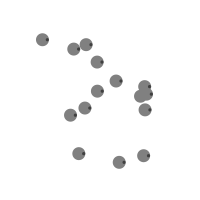

In [33]:
from navground.sim.ui import render_default_config

render_default_config.width = 200

scenario = sim.load_scenario("""
bounding_box:
  min_x: -2
  max_x: 12
  min_y: -2
  max_y: 12
groups:
  - number: 
      sampler: uniform
      from: 10
      to: 20
    radius: 0.5
    position:
      sampler: uniform
      from: [0, 0]
      to: [10, 10]  
""")

world = scenario.make_world(seed=0)
world

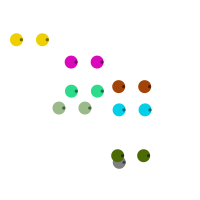

In [34]:
pair_agents(world, distance=1.0)
world

### Add an initializer

We can let the scenario apply the pairing automatically too, by wrapping it in a world initializer, i.e. a function that takes as input a world and an optional seed

In [35]:
def pairing_initializer(distance: float):
    def init(world: sim.World, seed: int | None = None) -> None:
        pair_agents(world, distance)
    return init

scenario.set_init('pair', pairing_initializer(distance=1.0))

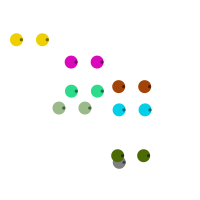

In [36]:
scenario.make_world(seed=0)

As we see, this initialization may give overlapping pairs, which we may avoid by moving pairs apart from each other in the initializer.

### Add a new scenario

Defining a new scenario that direcly applies the same initializer

In [37]:
class PairedScenario(sim.Scenario, name="Paired"):

    def __init__(self, distance: float = 1.0):
        super().__init__()
        self._distance = distance

    @property
    @sim.register(1.0, 'Distance between agents in a pair')
    def distance(self) -> float:
        return self._distance

    @distance.setter
    def distance(self, value) -> None:
        self._distance = max(0, value)   
    
    def init_world(self, world: sim.World, seed: int | None = None):
        # Apply sampler defined in YAML
        super().init_world(world, seed=seed)
        pair_agents(world, distance=self._distance)
        
        

is a more powerfull alternative to initializers because it can be direcly specified from YAML.

In [38]:
scenario = sim.load_scenario("""
type: Paired
bounding_box:
  min_x: -2
  max_x: 12
  min_y: -2
  max_y: 12
groups:
  - number: 
      sampler: uniform
      from: 10
      to: 20
    radius: 0.5
    position:
      sampler: uniform
      from: [0, 0]
      to: [10, 10]  
""")

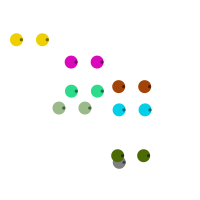

In [39]:
scenario.make_world(seed=0)

Properties like `distance` are now automatically assigned samplers too, i.e., we can vary them without any extra code:

In [40]:
scenario = sim.load_scenario("""
type: Paired
bounding_box:
  min_x: -2
  max_x: 12
  min_y: -2
  max_y: 12
distance: 
  sampler: uniform
  from: 0
  to: 2
groups:
  - number: 
      sampler: uniform
      from: 10
      to: 20
    radius: 0.5
    position:
      sampler: uniform
      from: [0, 0]
      to: [10, 10]  
""")

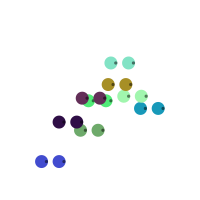

In [41]:
scenario.make_world(seed=2)

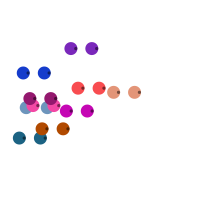

In [42]:
scenario.make_world(seed=3)

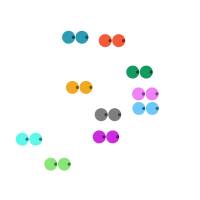

In [43]:
scenario.make_world(seed=4)

You find more details about extending scenarios in :doc:`../guides/extend/scenario`.